# Raw Data Processing - Road Stock in Norway 

This code represents the master thesis of the studednt Leo Liberkowski

## Preparation: Packages and data imports

We start by importing the necessary packages:

In [42]:
# Write all the necessary imports here
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from regression_functions import *
from dynamic_stock_model import *
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from pathlib import Path
from matplotlib.patches import Rectangle

In [25]:
personnal_path = Path.cwd().parents[1]
print(personnal_path)


c:\leo\double-diplome\COURSES\year 2\Master thesis\code\master_thesis


Then we import the different data into a Dataframe using the pandas read_excel function and we clean it.

## Data import

### Road Description

In [26]:
# Extracting data from the source file into a panda Dataframe
file = personnal_path / "data" / "01.Raw" / "Road_description" / "road_description.xlsx"

headers = pd.read_excel(file, sheet_name=0, header=None, skiprows=0, nrows=1, usecols="A:F").iloc[0]
data_road_description = pd.read_excel(
    file,
    sheet_name=0,
    header=0,
    usecols="A:F",
    index_col=[0, 1],
    engine="openpyxl",
)

data_road_description.iloc[0:10, 0:5]




Type 1  Type 2   Type3  Type 4
1935 length (m)  8344.0     0.0     0.0     0.0
     width (m)      7.0     0.0     0.0     0.0
     length (m)     0.0     0.0  7115.0     0.0
     width (m)      0.0     0.0     9.0     0.0
     length (m)     0.0     0.0     0.0  9998.0
     width (m)      0.0     0.0     0.0    10.0
1942 length (m)     0.0  1826.0     0.0     0.0
     width (m)      0.0     9.0     0.0     0.0
     length (m)  5955.0     0.0     0.0     0.0
     width (m)      6.0     0.0     0.0     0.0

We want to focus on the percentage of each type of road type in order to calculate the stock/inflow/outflow of road  per type from 1935 to 2050. Therefore, we have to see if we consider a constant coefficient, or if we try to do a regrerssion on the percentage. Let's now draw the repartition of each type of road from 1935 to 2026.

In [27]:
idx = data_road_description.index
# Create boolean masks to identify length and width rows
is_length = idx.get_level_values(1).astype(str).str.contains("length", case=False, na=False)
is_width  = idx.get_level_values(1).astype(str).str.contains("width",  case=False, na=False)

lengths = data_road_description[is_length].copy()
widths  = data_road_description[is_width].copy()

# Add a counter within each year
# This ensures that the first length matches the first width,
# the second length matches the second width, etc.
lengths["_pair"] = lengths.groupby(level=0).cumcount()
widths["_pair"]  = widths.groupby(level=0).cumcount()

# Set (year, pair_id) as index to align matching rows
lengths = lengths.reset_index(level=1, drop=True).set_index("_pair", append=True)
widths  = widths.reset_index(level=1, drop=True).set_index("_pair", append=True)

# Keep only the type columns (remove helper column if needed)
type_cols = [c for c in data_road_description.columns if c != "_pair"]
lengths = lengths[type_cols]
widths  = widths[type_cols]

# Compute area per pair (length × width)
areas_per_pair = lengths.mul(widths)

# Sum all pairs within each year
areas_per_year = areas_per_pair.groupby(level=0).sum()

# Create a new column for the total area
areas_per_year['Total Area'] = areas_per_year.sum(axis=1)

print(areas_per_year)

        Type 1    Type 2     Type3    Type 4  Total Area
1935   58408.0       0.0   64035.0   99980.0    222423.0
1942   35730.0   16434.0       0.0    1038.0     53202.0
1951   69789.0   21792.0    8406.0       0.0     99987.0
1959       0.0       0.0   27992.0  124584.0    152576.0
1968   98098.0   48296.0   52415.0       0.0    198809.0
1974   79407.0  162542.0       0.0       0.0    241949.0
1981       0.0  122347.0  132775.0   22710.0    277832.0
1985  197781.0  118404.0       0.0       0.0    316185.0
1989       0.0  256455.0   61110.0       0.0    317565.0
1994  174024.0  130160.0       0.0  123196.0    427380.0
1998       0.0  192593.0  157510.0   17514.0    367617.0
2001  240008.0  154601.0       0.0       0.0    394609.0
2005  439330.0  363187.0       0.0       0.0    802517.0
2008   33132.0  399163.0  211808.0       0.0    644103.0
2010  331892.0  295446.0   25920.0       0.0    653258.0
2012       0.0  452211.0  120231.0       0.0    572442.0
2014  198248.0    5488.0       

In [28]:
for col in areas_per_year.columns:
    if col != "Total Area":
        areas_per_year[f"{col} (%)"] = (
            areas_per_year[col] / areas_per_year["Total Area"]
        ) * 100

In [29]:
areas_per_year

,Type 1,Type 2,Type3,Type 4,Total Area,Type 1 (%),Type 2 (%),Type3 (%),Type 4 (%)
1935,58408.0,0.0,64035.0,99980.0,222423.0,26.259874,0.000000,28.789738,44.950387
1942,35730.0,16434.0,0.0,1038.0,53202.0,67.159129,30.889816,0.000000,1.951054
1951,69789.0,21792.0,8406.0,0.0,99987.0,69.798074,21.794833,8.407093,0.000000
1959,0.0,0.0,27992.0,124584.0,152576.0,0.000000,0.000000,18.346267,81.653733
1968,98098.0,48296.0,52415.0,0.0,198809.0,49.342837,24.292663,26.364501,0.000000
1974,79407.0,162542.0,0.0,0.0,241949.0,32.819726,67.180274,0.000000,0.000000
1981,0.0,122347.0,132775.0,22710.0,277832.0,0.000000,44.036324,47.789671,8.174004
1985,197781.0,118404.0,0.0,0.0,316185.0,62.552303,37.447697,0.000000,0.000000
1989,0.0,256455.0,61110.0,0.0,317565.0,0.000000,80.756695,19.243305,0.000000
1994,174024.0,130160.0,0.0,123196.0,427380.0,40.718798,30.455332,0.000000,28.825869


Let's look at the graphs of these figures:

<Figure size 640x480 with 0 Axes>

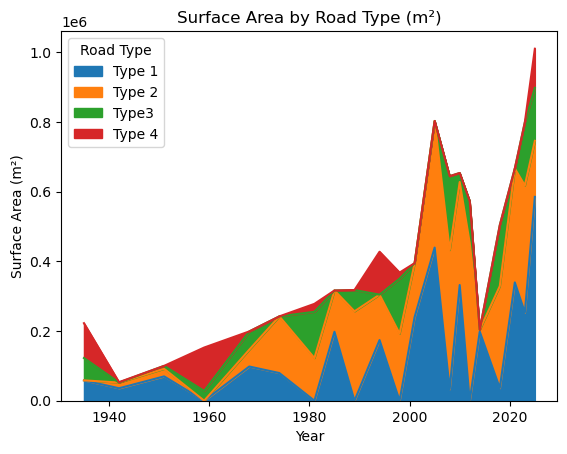

In [30]:
area_cols = ["Type 1", "Type 2", "Type3", "Type 4"]

plt.figure()

areas_per_year[area_cols].plot(kind="area")

plt.title("Surface Area by Road Type (m²)")
plt.xlabel("Year")
plt.ylabel("Surface Area (m²)")
plt.legend(title="Road Type")

plt.show()

<Figure size 640x480 with 0 Axes>

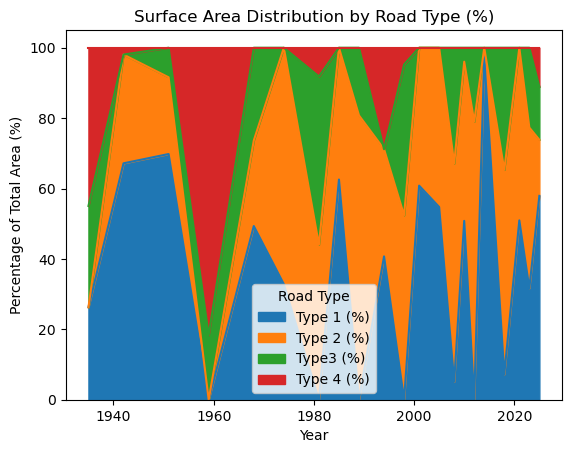

In [32]:
percent_cols = ["Type 1 (%)", "Type 2 (%)", "Type3 (%)", "Type 4 (%)"]

plt.figure()

areas_per_year[percent_cols].plot(kind="area")

plt.title("Surface Area Distribution by Road Type (%)")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Area (%)")
plt.legend(title="Road Type")

plt.show()

### Road Composition

We import the road composition table:

In [36]:
# Extracting data from the source file into a panda Dataframe
file = personnal_path / "data" / "01.Raw" / "Road_composition" / "road_composition.xlsx"

data_road_composition = pd.read_excel(
    file,
    sheet_name=0,
    header=[0, 1],   # rows 1-2 as a two-level column header
    index_col=0,     # column A as index
    engine="openpyxl"
)

# Keep only rows corresponding to Excel rows 3..8
# (because rows 1-2 are headers, first data row is already "Excel row 3")
data_road_composition = data_road_composition.iloc[0:6]

# Keep only columns B..P (i.e. remove column A which is index, keep next 15 cols)
data_road_composition = data_road_composition.iloc[:, 0:15]

data_road_composition

European & National Highways (Type 1)                \
                                              Surface course Binder course   
SMA/dense asphalt                                          4             0   
Gravel                                                     0             0   
Asphalt concrete                                           0             7   
Asphalt base                                               0             0   
Crush rock                                                 0             0   
Compacted natural soil                                     0             0   

                                                                       \
                       Base course Sub-base/Frost protection Subgrade   
SMA/dense asphalt                0                         0        0   
Gravel                           0                         0        0   
Asphalt concrete                 0                         0        0   
Asphalt base                    20                         0        0   
Crush rock                       0                       100        0   
Compacted natural soil           0                         0       20   

                       Country Road (Type 2)              \
                              Surface course Base course   
SMA/dense asphalt                          0           0   
Gravel                                     0           0   
Asphalt concrete                           4           0   
Asphalt base                               0          20   
Crush rock                                 0           0   
Compacted natural soil                     0           0   

                                                           \
                       Sub-base/Frost protection Subgrade   
SMA/dense asphalt                              0        0   
Gravel                                         0        0   
Asphalt concrete                               0        0   
Asphalt base                                   0        0   
Crush rock                                    80        0   
Compacted natural soil                         0       20   

                       Municipale Roads (Type3)                            \
                                 Surface course Binder course Base course   
SMA/dense asphalt                             0             0           0   
Gravel                                        0             0           0   
Asphalt concrete                              4             8           0   
Asphalt base                                  0             0           0   
Crush rock                                    0             0          20   
Compacted natural soil                        0             0           0   

                                                 Gravel Roads (Type4)  \
                       Sub-base/Frost protection        Wearing Layer   
SMA/dense asphalt                              0                    0   
Gravel                                         0                   10   
Asphalt concrete                               0                    0   
Asphalt base                                   0                    0   
Crush rock                                    60                    0   
Compacted natural soil                         0                    0   

                                   
                       Base layer  
SMA/dense asphalt               0  
Gravel                          0  
Asphalt concrete                0  
Asphalt base                    0  
Crush rock                     30  
Compacted natural soil          0

Let's plot a graph to have an idea on the different layers:

In [ ]:
def build_road_layers(df: pd.DataFrame):
    # Road types in the order they appear in the file
    road_types_in_order = pd.Index(df.columns.get_level_values(0)).drop_duplicates().tolist()

    road_layers = {}
    tidy_rows = []

    for road_type in road_types_in_order:
        # slice: columns for this road type, keeps layer order
        df_type = df.loc[:, road_type]

        layers = []
        for layer_name in df_type.columns:
            # non-zero materials for this layer
            nz = df_type[layer_name]
            nz = nz[nz != 0]

            for material, thickness in nz.items():
                rec = {
                    "road_type": road_type,
                    "layer": layer_name,
                    "material": material,
                    "thickness": float(thickness),
                }
                layers.append(rec)
                tidy_rows.append(rec)

        road_layers[road_type] = layers

    tidy_df = pd.DataFrame(tidy_rows, columns=["road_type", "layer", "material", "thickness"])
    return road_layers, tidy_df


road_layers, road_layers_df = build_road_layers(data_road_composition)



(dict_keys(['European & National Highways (Type 1)', 'Country Road (Type 2)', 'Municipale Roads (Type3)', 'Gravel Roads (Type4)']),
                                road_type                      layer  \
 0  European & National Highways (Type 1)             Surface course   
 1  European & National Highways (Type 1)              Binder course   
 2  European & National Highways (Type 1)                Base course   
 3  European & National Highways (Type 1)  Sub-base/Frost protection   
 4  European & National Highways (Type 1)                   Subgrade   
 
                  material  thickness  
 0       SMA/dense asphalt        4.0  
 1        Asphalt concrete        7.0  
 2            Asphalt base       20.0  
 3              Crush rock      100.0  
 4  Compacted natural soil       20.0  )

In [46]:
def plot_road_section(road_layers_df, road_type, layer_order=None, width=4):
    """
    Draw a simple road cross-section (stacked layers) for one road type.
    Expects road_layers_df columns: road_type, layer, material, thickness
    """
    df = road_layers_df[road_layers_df["road_type"] == road_type].copy()
    if df.empty:
        raise ValueError(f"No layers found for road_type='{road_type}'")

    # If multiple materials per same layer exist, we stack them within that layer (rare but supported)
    # Preserve order of appearance unless a layer_order is given
    if layer_order is None:
        # order by first appearance in the filtered df
        layer_order = df["layer"].drop_duplicates().tolist()

    # sort layers in desired order
    df["layer"] = pd.Categorical(df["layer"], categories=layer_order, ordered=True)
    df = df.sort_values(["layer"])

    # A simple color mapping by material (auto-generated, stable-ish)
    materials = df["material"].unique().tolist()
    cmap = plt.get_cmap("tab20")
    material_to_color = {m: cmap(i % cmap.N) for i, m in enumerate(materials)}

    # Draw from bottom to top
    total_thickness = df["thickness"].sum()
    y = 0.0

    fig, ax = plt.subplots(figsize=(8, 6))

    # We'll iterate layer-by-layer
    for layer_name in layer_order:
        chunk = df[df["layer"] == layer_name]
        if chunk.empty:
            continue

        # If there are multiple rows in same layer, stack them (bottom-to-top) within that layer
        for _, row in chunk.iterrows():
            t = float(row["thickness"])
            mat = row["material"]
            color = material_to_color[mat]

            rect = Rectangle((0, y), width, t, facecolor=color, edgecolor="black", linewidth=1)
            ax.add_patch(rect)

            # label in the middle of the rectangle (skip if too thin)
            if t >= 2:
                ax.text(width/2, y + t/2,
                        f"{layer_name}\n{mat}\n{t:g}",
                        ha="center", va="center", fontsize=9)
            else:
                ax.text(width + 0.1, y + t/2,
                        f"{layer_name} • {mat} • {t:g}",
                        ha="left", va="center", fontsize=9)

            y += t

    ax.set_xlim(-0.5, width + 3.5)
    ax.set_ylim(0, max(total_thickness * 1.05, 1))
    ax.set_xticks([])
    ax.set_ylabel("Thickness (cm)")
    ax.set_title(road_type)
    ax.set_aspect("auto")
    plt.show()

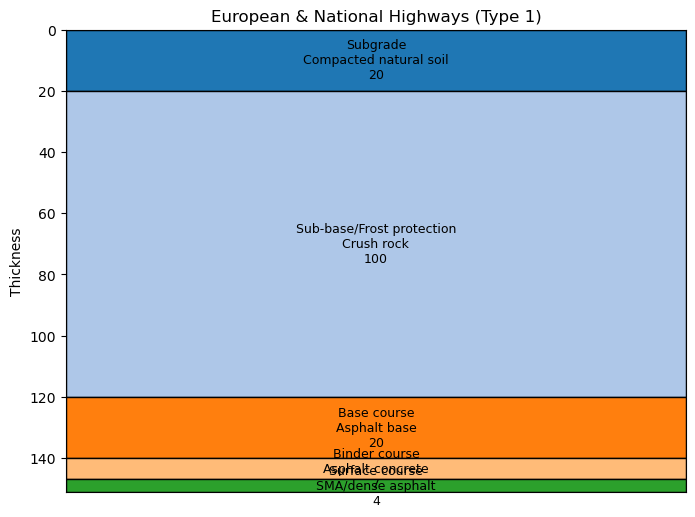

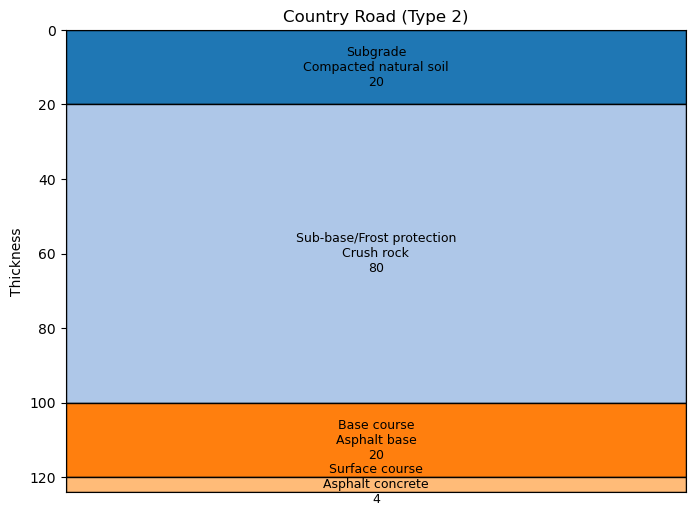

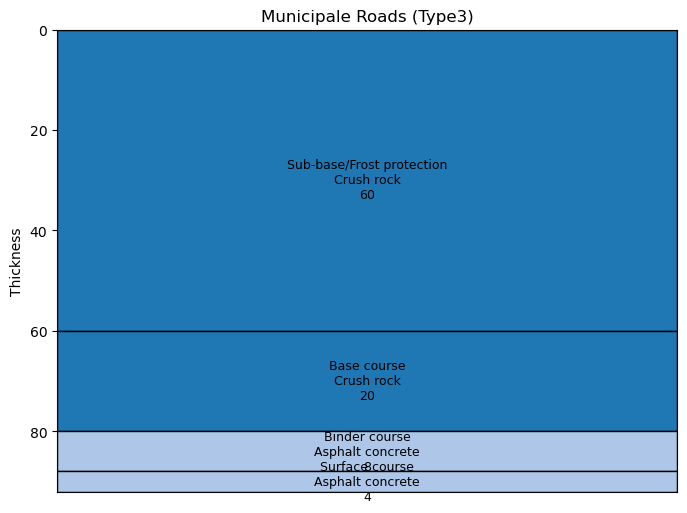

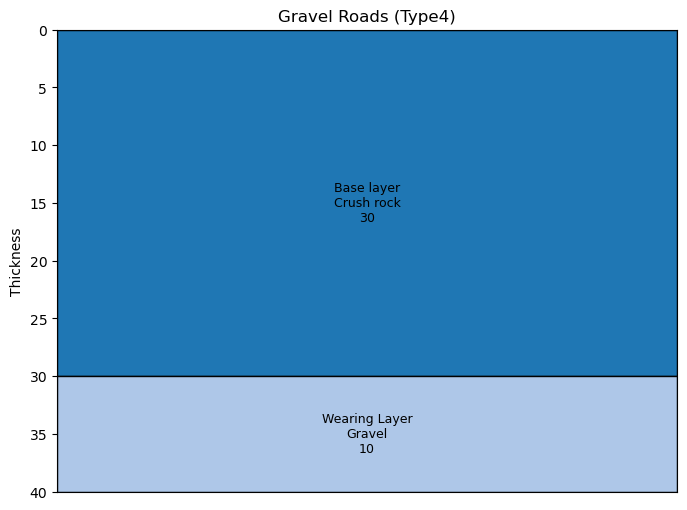

In [45]:
plot_road_section(road_layers_df, "European & National Highways (Type 1)")
plot_road_section(road_layers_df, "Country Road (Type 2)")
plot_road_section(road_layers_df, "Municipale Roads (Type3)")
plot_road_section(road_layers_df, "Gravel Roads (Type4)")

We now calculate the number of dwelling in multi-dwellings buildings

In [40]:
years = pd.Series(range(1600, 2051, 1))
nb_dwellings = pd.DataFrame(columns=['SFH', 'TH', 'MFH', 'AB'], index=years)
nb_dwellings.index.name = 'Year'

'''To find the number of dwellings in the building, we assume that the number of dwellings is the ceiling of total area divided by the mean dwelling area of this period 
since area of dwelling in AB and MFH are often smaller than in TH and SFH 
'''
# unit is m²
for year in range(1600, 1915, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 213 // 81.5 + 1
    nb_dwellings.loc[year, 'AB'] = 1713 // 81.5 +1

for year in range(1915, 1949, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 394 // 81.5 +1
    nb_dwellings.loc[year, 'AB'] = 754 // 81.5 + 1

for year in range(1949, 1968, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 397 // 76 + 1
    nb_dwellings.loc[year, 'AB'] = 1981 // 76 + 1

for year in range(1968, 1975, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 460 // 76 + 1
    nb_dwellings.loc[year, 'AB'] = 4297 // 76 + 1

for year in range(1975, 1982, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 179 // 84 + 1
    nb_dwellings.loc[year, 'AB'] = 1227 //84 + 1

for year in range(1982, 1990, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 851 // 84 + 1
    nb_dwellings.loc[year, 'AB'] = 3348 // 84 + 1

for year in range(1990, 2000, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 682 // 84 + 1
    nb_dwellings.loc[year, 'AB'] = 4890 // 84 + 1

for year in range(2000, 2006, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 497 // 87.3 + 1
    nb_dwellings.loc[year, 'AB'] = 2344 // 87.3 + 1

for year in range(2006, 2013, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 594 // 87.3 + 1
    nb_dwellings.loc[year, 'AB'] = 4660 // 87.3 + 1

for year in range(2013, 2051, 1):
    nb_dwellings.loc[year, 'SFH'] = 1
    nb_dwellings.loc[year, 'TH'] = 1
    nb_dwellings.loc[year, 'MFH'] = 539 // 87.3 + 1
    nb_dwellings.loc[year, 'AB'] = 2210 // 87.3 + 1

display(nb_dwellings)
nb_dwellings.to_excel(personnal_path + 'Project-TEP4290\\data\\02.Processed_baseline\\buildings\\ufapd\\nb_dwellings_in_AB_MFH.xlsx', index=True)

,SFH,TH,MFH,AB
Year,,,,
1600,1,1,3.0,22.0
1601,1,1,3.0,22.0
1602,1,1,3.0,22.0
1603,1,1,3.0,22.0
1604,1,1,3.0,22.0
...,...,...,...,...
2046,1,1,7.0,26.0
2047,1,1,7.0,26.0
2048,1,1,7.0,26.0


In [41]:
data_ufapd = data_area / nb_dwellings
data_ufapd.to_excel(personnal_path + 'Project-TEP4290\\data\\02.Processed_baseline\\buildings\\ufapd\\data_ufapd.xlsx', index=True)

We print the data:

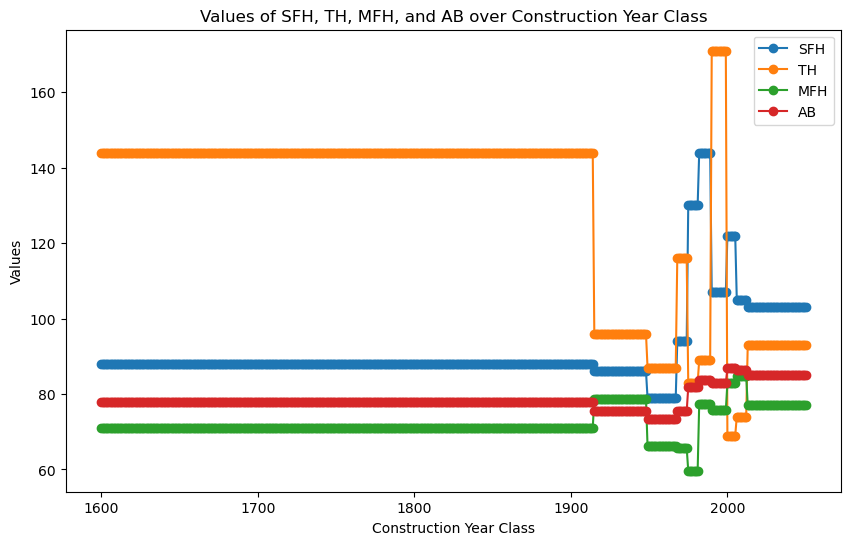

In [43]:
plt.figure(figsize=(10, 6))

# Tracer les valeurs des colonnes SFH, TH, MFH et AB en fonction de la colonne construction year class
plt.plot(data_ufapd.index, data_ufapd['SFH'], label='SFH', marker='o')
plt.plot(data_ufapd.index, data_ufapd['TH'], label='TH', marker='o')
plt.plot(data_ufapd.index, data_ufapd['MFH'], label='MFH', marker='o')
plt.plot(data_ufapd.index, data_ufapd['AB'], label='AB', marker='o')

# Ajouter des labels et un titre
plt.xlabel('Construction Year Class')
plt.ylabel('Values')
plt.title('Values of SFH, TH, MFH, and AB over Construction Year Class')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

### Population

We import the data:

In [19]:
# Extracting data from the source file into a panda Dataframe
#file_hist = "C:\\leo\\double-diplome\\COURSES\\S2\\TEP4290\\project\\Project-TEP4290\\data\\raw\\population\\population\\population_historique_1800_2024.xlsx"
file_hist = personnal_path + 'Project-TEP4290\\data\\01.Raw\\population\\population\\population_historique_1800_2024.xlsx'
#file_futur = "C:\\leo\\double-diplome\\COURSES\\S2\\TEP4290\\project\\Project-TEP4290\\data\\raw\\population\\population\\population_projection_2020_2070.xlsx"
file_futur = personnal_path + 'Project-TEP4290\\data\\01.Raw\\population\\population\\population_projection_2020_2070.xlsx'

headers_futur = pd.read_excel(file_futur, sheet_name=0, header=None, skiprows=3, nrows=1, usecols="C:K").iloc[0]
years=pd.concat([pd.read_excel(file_hist, sheet_name=0, header=None, skiprows=1, nrows=144, usecols="A").squeeze(), pd.read_excel(file_futur, sheet_name=0, header=None, skiprows=15, nrows=25, usecols="A").squeeze()]) 
data_hist = pd.read_excel(file_hist, sheet_name=0, header=None, skiprows=1, nrows=140, usecols="B").squeeze()
data_futur = pd.read_excel(file_futur, sheet_name=0, header=None, skiprows=10, nrows=29, usecols="C:K")

data_hist*=1000
data_futur*=1000000
data_pop = pd.DataFrame(columns=["Year"] + headers_futur.tolist())
data_pop["Year"] = years

for col in headers_futur:
    data_pop.loc[data_pop["Year"] <= 2020, col] = data_hist.values


data_pop.loc[data_pop["Year"] > 2020, headers_futur.tolist()] = data_futur.values

data_pop


,Year,Central,Fécondité basse,Fécondité haute,Espérance de vie basse,Espérance de vie haute,Solde migratoire bas,Solde migratoire haut,Population basse,Population haute
0,1801,29361000,29361000,29361000,29361000,29361000,29361000,29361000,29361000,29361000
1,1806,29648000,29648000,29648000,29648000,29648000,29648000,29648000,29648000,29648000
2,1811,30271000,30271000,30271000,30271000,30271000,30271000,30271000,30271000,30271000
3,1816,30573000,30573000,30573000,30573000,30573000,30573000,30573000,30573000,30573000
4,1821,31578000,31578000,31578000,31578000,31578000,31578000,31578000,31578000,31578000
...,...,...,...,...,...,...,...,...,...,...
20,2046,69300000.0,67800000.0,70700000.0,68200000.0,70400000.0,67600000.0,71000000.0,65100000.0,73700000.0
21,2047,69300000.0,67700000.0,70800000.0,68100000.0,70500000.0,67500000.0,71100000.0,64900000.0,73900000.0
22,2048,69300000.0,67600000.0,70900000.0,68100000.0,70500000.0,67400000.0,71100000.0,64700000.0,74100000.0
23,2049,69300000.0,67500000.0,71000000.0,68000000.0,70600000.0,67300000.0,71200000.0,64400000.0,74300000.0


We print the data:

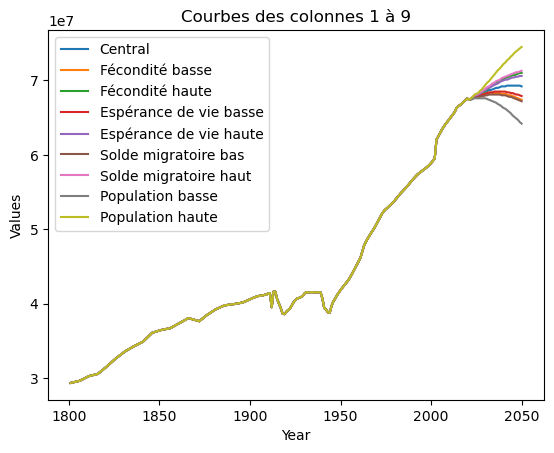

In [20]:
x = data_pop.iloc[:, 0]

# Tracer les courbes pour les colonnes 1 à 9
for col in data_pop.columns[1:]:
    plt.plot(x, data_pop[col], label=col)

# Ajouter les légendes et les labels
plt.xlabel(data_pop.columns[0])
plt.ylabel('Values')
plt.title('Courbes des colonnes 1 à 9')
plt.legend()

# Afficher le graphique
plt.show()

### PpD

We import the data:

In [21]:
# Extracting data from the source file into a panda Dataframe
#file = "C:\\leo\\double-diplome\\COURSES\\S2\\TEP4290\\project\\Project-TEP4290\\data\\raw\\population\\ppd\\PpD.xlsx"
file = personnal_path + 'Project-TEP4290\\data\\01.Raw\\population\\ppd\\PpD.xlsx'

# We read the data and store it in a Dataframe called "data", using the read_excel() panda function
headers = pd.read_excel(file, sheet_name=1, header=None, skiprows=0, nrows=1, usecols="A:B").iloc[0]
data_PpD = pd.read_excel(file, sheet_name=1,  header=None, skiprows=1,nrows=11, usecols="A:B")

data_PpD.columns = headers

# This is just to replace all the void values in "data" by 0, which makes things easier
data_PpD.fillna(0, inplace=True)
data_PpD

,Year,PpD
0,1962,3.10
1,1968,3.06
2,1975,2.89
3,1982,2.71
4,1990,2.58
5,1999,2.40
6,2008,2.30
7,2013,2.24
8,2018,2.19
9,2019,2.18


We print the data:

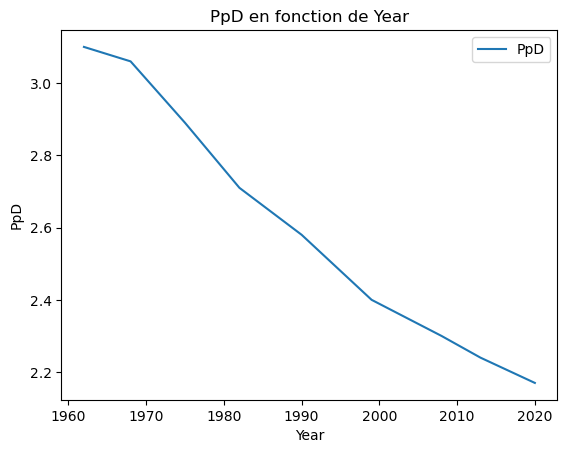

In [22]:
plt.plot(data_PpD['Year'], data_PpD['PpD'], label='PpD')

# Ajouter les légendes et les labels
plt.xlabel('Year')
plt.ylabel('PpD')
plt.title('PpD en fonction de Year')
plt.legend()

# Afficher le graphique
plt.show()

## Regression from 1600 to 2050 for the different data sets

The aim is now to obtain the stock, the inputs and the outputs for every year from 1600 to 2050.

For this period, we will use the following method to obtain the stock/input/output.  
1) We will compute a regression on the population, the people per dwelling and on the percentage of repartition of the types of dwelling.  
2) Then, we will obtain the stock thanks to these values with the relation: $stock= \frac{population}{ppd}$
3) Finally, we will use a stock-driven model in order to obtain the input, output and stock change


First, let's create a dataframe to stock our regressions:

In [23]:
years = list(range(1600,2051))
years=np.array(years)
# Créer un DataFrame avec une colonne 'construction year class'
years_pd = pd.DataFrame(years, columns=['construction year class'])

### Population

We will now focus on the population, and we will calculate the regression from 1600 to 2050.

In [24]:
#Dataset
label_courbes=['Polynomial degree 1', 'Polynomial degree 2', 'Polynomial degree 3', 'Logistic', 'Natural cubic spline']

#We add a new row to have a limit condition in 1600 and we assume that the population is 0
new_row = {'Year': 1600, 'Central': 0, 'Fécondité basse': 0, 'Fécondité haute': 0, 'Espérance de vie basse': 0, 'Espérance de vie haute': 0, 'Solde migratoire bas': 0, 'Solde migratoire haut': 0, 'Population basse': 0, 'Population haute': 0}
new_row_df = pd.DataFrame([new_row])
data_pop_new = pd.concat([new_row_df,data_pop], ignore_index=True)

#we create a new list to stock the future regression values
regression_finale_pop=[years,[],[],[],[],[]]


#### Polynomial regression

In [25]:
columns_to_process=[1,2,3,4,5,6,7,8,9]
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp,poly_out=polynomial_deg123_reg(reg_years, reg_values, years)
    regression_finale_pop[1].append(poly_out[0])
    regression_finale_pop[2].append(poly_out[1])
    regression_finale_pop[3].append(poly_out[2])


 the polynomial our fit created is: 
 
1.844e+05 x - 3.105e+08.
 the polynomial our fit created is: 
       2
310.6 x - 1.004e+06 x + 8.253e+08.
 the polynomial our fit created is: 
       3             2
2.039 x - 1.104e+04 x + 2e+07 x - 1.208e+10.
 the polynomial our fit created is: 
 
1.818e+05 x - 3.055e+08.
 the polynomial our fit created is: 
       2
293.8 x - 9.428e+05 x + 7.689e+08.
 the polynomial our fit created is: 
       3             2
1.886 x - 1.021e+04 x + 1.849e+07 x - 1.117e+10.
 the polynomial our fit created is: 
 
1.869e+05 x - 3.152e+08.
 the polynomial our fit created is: 
       2
326.7 x - 1.064e+06 x + 8.796e+08.
 the polynomial our fit created is: 
       3             2
2.186 x - 1.184e+04 x + 2.145e+07 x - 1.295e+10.
 the polynomial our fit created is: 
 
1.825e+05 x - 3.068e+08.
 the polynomial our fit created is: 
       2
298.1 x - 9.587e+05 x + 7.835e+08.
 the polynomial our fit created is: 
       3             2
1.927 x - 1.043e+04 x + 1.889e+07 x -

#### Logistic Regression

In [26]:
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=logistic_reg(reg_years, reg_values, years, 'black', 0, 0, 1000000000, 10, 80000000)
    regression_finale_pop[4].append(poly_out)
  

The optimal choice of parameters for the logistic function, given the sample data, is [1.90581364e+03 9.44858965e+01 9.99999306e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90558387e+03 9.59674729e+01 9.99999955e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90603078e+03 9.31034694e+01 9.99998970e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90564485e+03 9.55889922e+01 9.99999239e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90598955e+03 9.33383677e+01 9.99998240e+00 8.00000000e+07] (ti, tau, C0, C1).
The optimal choice of parameters for the logistic function, given the sample data, is [1.90553598e+03 9.63337647e+01 9.99999171e+00 8.00000000e+07] (ti, tau, C0, C1)

#### Cubic regression

In [27]:
for col in columns_to_process:
    reg_years = data_pop_new.iloc[0:data_pop_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_pop_new.iloc[0:data_pop_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=natural_cubic_line_reg(reg_years, reg_values, years, 'black')
    regression_finale_pop[5].append(poly_out)


The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model
The ncs_model


#### Comparison of the regressions

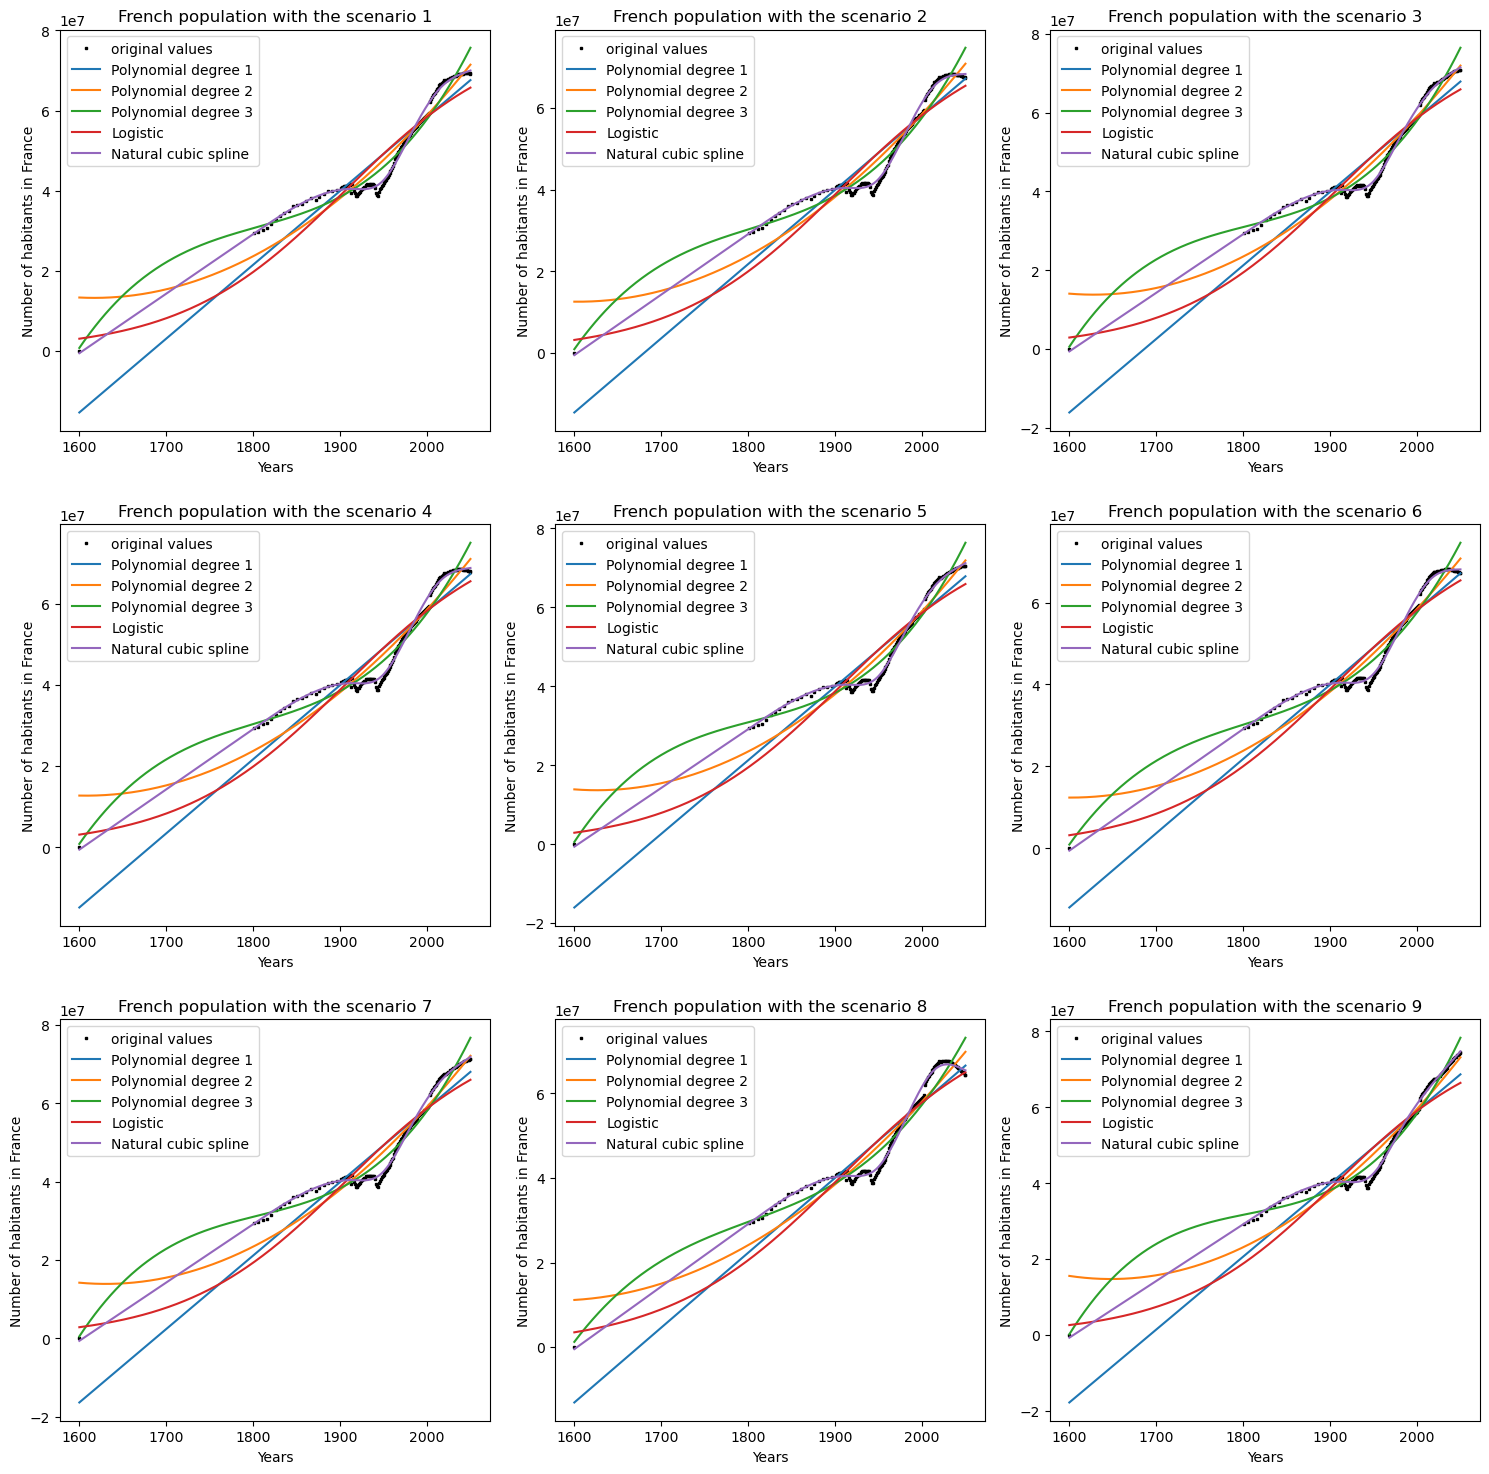

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Itérer sur les colonnes et les axes pour tracer les graphiques
for col, ax in enumerate(axes.flatten()):
    ax.plot(reg_years, data_pop_new.iloc[:, col+1], 's', color='black', markersize=2, label='original values')
    for i in range(1, 6):
        x_values = regression_finale_pop[0]
        y_values = regression_finale_pop[i][col]
        ax.plot(x_values, y_values, label=label_courbes[i-1])
    ax.set_xlabel('Years')
    ax.set_ylabel(f'Number of habitants in France')
    ax.set_title(f'French population with the scenario {col+1}')
    ax.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

We will use the natural cubic spline for our regression method.

### PpD

#### Preparation of the Data

In [29]:
label_courbes=['Polynomial degree 1', 'Polynomial degree 2', 'Polynomial degree 3', 'Logistic', 'Natural cubic spline']
# Supprimez les lignes avec des valeurs manquantes
data_PpD = data_PpD.dropna(subset=[data_PpD.columns[0], data_PpD.columns[1]])
new_row = {'Year': 1600, 'PpD': 4}
new_row_df = pd.DataFrame([new_row])
data_PpD_new = pd.concat([new_row_df,data_PpD], ignore_index=True)

#ajout de n lignes pour la regression encessitant 10 valeurs
n=2
for i in range(n):
    new_row_bis = {'Year': round((data_PpD_new.iloc[0,0]+data_PpD_new.iloc[1,0])/2), 'PpD': (data_PpD_new.iloc[0,1]+data_PpD_new.iloc[1,1])/2}
    new_row_bis_df = pd.DataFrame([new_row_bis])
    data_PpD_new = pd.concat([data_PpD_new.iloc[:1], new_row_bis_df, data_PpD_new.iloc[1:]], ignore_index=True)


# Transformer les colonnes spécifiques en tableaux numpy

regression_finale_PpD=[years,[],[],[],[],[]]

#### Polynomial Regression

In [34]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp,poly_out=polynomial_deg123_reg(reg_years, reg_values, years)
    regression_finale_PpD[1].append(poly_out[0])
    regression_finale_PpD[2].append(poly_out[1])
    regression_finale_PpD[3].append(poly_out[2])


 the polynomial our fit created is: 
 
-0.004211 x + 10.92.
 the polynomial our fit created is: 
            2
-1.429e-05 x + 0.04804 x - 36.44.
 the polynomial our fit created is: 
            3             2
-1.043e-07 x + 0.0005524 x - 0.9749 x + 576.8.


#### Logistic regression

In [35]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    poly_inp, poly_out=logistic_reg(reg_years, reg_values, years, 'black', 0, 0, 1000000, 1000000, 1000000)
    regression_finale_PpD[4].append(poly_out)


The optimal choice of parameters for the logistic function, given the sample data, is [1.97517660e+03 2.17326117e+01 3.77470313e+00 1.96673326e+00] (ti, tau, C0, C1).


#### Cubic Regression

In [36]:
columns_to_process=[1]
for col in columns_to_process:
    reg_years = data_PpD_new.iloc[0:data_PpD_new.shape[0], 0].to_numpy(dtype=np.float64)
    reg_values = data_PpD_new.iloc[0:data_PpD_new.shape[0], col].to_numpy(dtype=np.float64)
    print(reg_years)
    print(reg_values)
    poly_inp, poly_out=natural_cubic_line_reg(reg_years, reg_values, years, 'black')
    regression_finale_PpD[5].append(poly_out)


[1600. 1690. 1781. 1962. 1968. 1975. 1982. 1990. 1999. 2008. 2013. 2018.
 2019. 2020.]
[4.    3.775 3.55  3.1   3.06  2.89  2.71  2.58  2.4   2.3   2.24  2.19
 2.18  2.17 ]
The ncs_model


c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
  polynomial = np.poly1d(np.polyfit(x, y, 3))
c:\Users\Clothilde\Documents\GitHub\Project-TEP4290\tep4290_group_02\01.Raw_processing\regression_functions.py:204: RankWarning: Polyfit may be poorly conditioned
 

#### Comparison of the regressions 

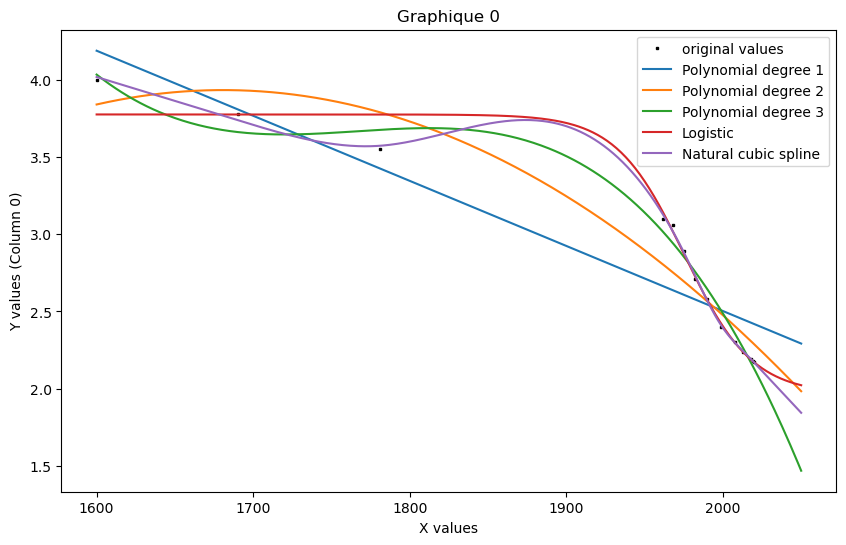

In [38]:
for col in range(1):
    plt.figure(figsize=(10, 6))
    plt.plot(reg_years, data_PpD_new.iloc[:,col+1], 's', color = 'black', markersize = 2, label = f'original values')
    for i in range(1,6):
        x_values = regression_finale_PpD[0]
        y_values = regression_finale_PpD[i][col]
        plt.plot(x_values, y_values, label=label_courbes[i-1])
    plt.xlabel('X values')
    plt.ylabel(f'Y values (Column {col})')
    plt.title(f'Graphique {col}')
    plt.legend()
    plt.show()

We finally choose the regression natural cubic spline

## Baseline scenario

We have now data sets from 1600 to 2050 for the population, the people per dwelling and the repartition of the different types of dwelling.
We will now stock these data sets in a DataFrame and calculate our baseline scenario to help us for our scenarios.
 

### Stock-driven model from 1600 to 2050

In [44]:
# create a new dataframe to stock the final data
data_final= pd.DataFrame(columns=['Year', 'Population', 'Inflow', 'Outflow', 'Stock Change', 'Stock', 'PpD'])
data_final['Year']=years
data_final['Population']=regression_finale_pop[-1][0] #we choose the cubic spline regression (with the [-1]) and the central scenario (with the [0])
data_final['PpD']=regression_finale_PpD[-1][0] #we choose the cubic spline regression (with the [-1])
# replace negative value in population and people per dwelling by 0
data_final.loc[data_final['Population'] < 0, 'Population'] = 0
data_final['Stock']=data_final['Population']/data_final['PpD']
data_final.fillna(0, inplace=True)
display(data_final)


C:\Users\Clothilde\AppData\Local\Temp\ipykernel_18532\3129730137.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_final.fillna(0, inplace=True)


,Year,Population,Inflow,Outflow,Stock Change,Stock,PpD
0,1600,0.000000e+00,0,0,0,0.000000e+00,4.017039
1,1601,0.000000e+00,0,0,0,0.000000e+00,4.013938
2,1602,0.000000e+00,0,0,0,0.000000e+00,4.010837
3,1603,0.000000e+00,0,0,0,0.000000e+00,4.007736
4,1604,3.135472e+03,0,0,0,7.829607e+02,4.004635
...,...,...,...,...,...,...,...
446,2046,6.967725e+07,0,0,0,3.691195e+07,1.887661
447,2047,6.975382e+07,0,0,0,3.716569e+07,1.876834
448,2048,6.982985e+07,0,0,0,3.742208e+07,1.866006
449,2049,6.990560e+07,0,0,0,3.768132e+07,1.855179


We now compute the stock driven model method in order to find the inflows, the outflows and the stock change.

In [45]:
#calculation of the outflow/inflows/stock change
a = (40 - 80) / 20
b = (200- 80) / 20
Stock= data_final.loc[:,'Stock'].to_numpy()
TestDSMX = DynamicStockModel(t = np.arange(1600,2051,1), s = Stock, lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([80]), 'StdDev': np.array([20]) })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_C_sd, O_C_sd, I_sd, ExitFlag = TestDSMX.compute_stock_driven_model()
O_sd, ExitFlag   = TestDSMX.compute_outflow_total()
DS_sd, ExitFlag  = TestDSMX.compute_stock_change()
Bal_sd, ExitFlag = TestDSMX.check_stock_balance()
#print(TestDSMX.s_c)

#print(type(O_sd))
data_final.loc[:,'Outflow']=  O_sd[:]
data_final.loc[:,'Inflow']=  I_sd[:] 
data_final.loc[:,'Stock Change']=  DS_sd[:]
print(data_final.head())

stock_2011=data_final.loc[data_final['Year']==2011]['Stock']

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow is not present.<br>Total stock is present with 451 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

C:\Users\Clothilde\AppData\Local\Temp\ipykernel_18532\329853508.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.27371290e+00 1.10459902e+02 2.29883720e+02
 3.61367310e+02 5.05751985e+02 6.63893562e+02 8.36657085e+02
 1.02491098e+03 1.

### Inflow-driven model for each dwelling types

In [46]:
data_typesplit_percentage = pd.read_excel(personnal_path + 'Project-TEP4290\\data\\02.Processed_baseline\\buildings\\type_split\\data_percentage.xlsx', header = 0, index_col = 0)
data_typesplit_percentage.reset_index(drop=True, inplace=True)

data_final['Inflow SFH'] = data_final['Inflow'] * data_typesplit_percentage['SFH (%)'] * 0.01
data_final['Inflow TH'] = data_final['Inflow']*data_typesplit_percentage['TH (%)']*0.01
data_final['Inflow MFH'] = data_final['Inflow']*data_typesplit_percentage['MFH (%)']*0.01
data_final['Inflow AB'] = data_final['Inflow']*data_typesplit_percentage['AB (%)']*0.01

#### AB values

In [48]:
TestDSMX_AB = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow AB'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([80]), 'StdDev': np.array([20])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_AB.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_AB.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_AB.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_AB.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_AB.compute_stock_change()

data_final['Stock AB'] = S_id[:]
data_final['Outflow AB']=  O_id[:]
data_final['Stock Change AB']=  SC_id[:]
outflow_b_c_AB=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### TH values

In [49]:
TestDSMX_TH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow TH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_TH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_TH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_TH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_TH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_TH.compute_stock_change()

data_final['Stock TH'] = S_id[:]
data_final['Outflow TH']=  O_id[:]
data_final['Stock Change TH']=  SC_id[:]
outflow_b_c_TH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### MFH values

In [50]:
TestDSMX_MFH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow MFH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_MFH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_MFH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_MFH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_MFH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_MFH.compute_stock_change()

data_final['Stock MFH'] = S_id[:]
data_final['Outflow MFH']=  O_id[:]
data_final['Stock Change MFH']=  SC_id[:]
outflow_b_c_MFH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

#### SFH values

In [51]:
TestDSMX_SFH = DynamicStockModel(t = np.arange(1600,2051,1), i = data_final['Inflow SFH'].to_numpy(), lt = {'Type': 'TruncNorm', 'a': np.array([a]), 'b': np.array([b]),  'Mean': np.array([2]), 'StdDev': np.array([80])  })
print(TestDSMX.dimension_check())

CheckStr, ExitFlag = TestDSMX.dimension_check()

S_c_id, ExitFlag = TestDSMX_SFH.compute_s_c_inflow_driven()
S_id, ExitFlag = TestDSMX_SFH.compute_stock_total()
O_c_id, ExitFlag = TestDSMX_SFH.compute_o_c_from_s_c()
O_id, ExitFlag = TestDSMX_SFH.compute_outflow_total()
SC_id, ExitFlag = TestDSMX_SFH.compute_stock_change()

data_final['Stock SFH'] = S_id[:]
data_final['Outflow SFH']=  O_id[:]
data_final['Stock Change SFH']=  SC_id[:]
outflow_b_c_SFH=  O_c_id[:]
print(data_final.head())

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 451 years.<br>Inflow vector is present with 451 years.<br>Total stock is present with 451 years.<br>Stock by cohorts is present with 451 years and 451 cohorts.<br>Total outflow is present with 451 years.<br>Outflow by cohorts is present with 451 years and 451 cohorts.<br>Lifetime distribution is present with type TruncNorm and mean [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80\n 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80

### Data exports

In [54]:
#data_final.to_excel("C:\\leo\\double-diplome\\data_ts_construction_dw.xlsx", index=False)
data_final.to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\data_ts_construction_dw.xlsx", index=False)
pd.DataFrame(outflow_b_c_SFH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_SFH.xlsx", index=True)
pd.DataFrame(outflow_b_c_MFH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_MFH.xlsx", index=True)
pd.DataFrame(outflow_b_c_TH).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_TH.xlsx", index=True)
pd.DataFrame(outflow_b_c_AB).to_excel(personnal_path + "Project-TEP4290\\data\\05.Results\\baseline\\outflow_b_c_AB.xlsx", index=True)